In [1]:
import numpy as np
import pyintersection as pyi
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Define some help functions

## Define plot functions

In [2]:
def plot_rpoints(axis, rpoints, c=None, s=None, **kwargs):
    ix, iy, iz = rpoints[:, 4:5], rpoints[:, 5:6], rpoints[:, 6:7]
    axis.scatter(ix, iy, iz, c=c, s=s, **kwargs)
    
def plot_mpoints(axis, mpoints, c=None, s=None, **kwargs):
    ix, iy, iz = mpoints[:, 2:3], mpoints[:, 3:4], mpoints[:, 4:5]
    axis.scatter(ix, iy, iz, c=c, s=s, **kwargs)
    
def plot_rawpoints(axis, points, c=None, s=None, **kwargs):
    ix, iy, iz = points[:, 0:1], points[:, 1:2], points[:, 2:3]
    axis.scatter(ix, iy, iz, c=c, s=s, **kwargs)
    
def plot_surface(axis, mesh, **kwargs):
    ix, iy, iz = mesh
    axis.plot_surface(ix, iy, iz, **kwargs)

## Define plaine and sphere create mesh functions

In [79]:
def create_sphere_mesh():
    r = 5.0
    L, W = 2*np.pi, np.pi
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u)*np.sin(v)*r
    y = np.sin(u)*np.sin(v)*r
    z = np.cos(v)*r
    return x, y, z

def create_plain_mesh(n, D=0):
    L, W = 7, 7
    kx, ky = 31, 31
 
    n = n / np.linalg.norm(n)
    x, y = np.mgrid[-L:L:kx*1j, -W:W:ky*1j]
    A, B, C = n
    z = -(A*x+B*y+D)/C
    return x, y, z

## Define manifold and point generator functions

In [4]:
def create_manifold_generator(generate_point=None, points_count=40):
    scaling = 1
    def generator(n, t, atol, points_count=points_count):
        size = int(points_count**0.5)
        twidth = atol * scaling
        nwidth = atol * scaling
        ts = np.linspace(t - twidth / 2, t + twidth / 2, size)
        ns = np.linspace(n - nwidth / 2, n + nwidth / 2, size)
        res = np.zeros((len(ns) * len(ts), 5))

        for i, n in enumerate(ns):
            for j, t in enumerate(ts):
                res[j + len(ts) * i] = n, t, *generate_point(n, t)
        return res
    return generator

def create_point_generator(vec_par, vec_offset):
    def generator(n, t):
        return vec_offset * n + vec_par * t
    return generator

def sphere_point_generator(n, t):
    r = 5.0
    return np.array([
        np.cos(n)*np.sin(t)*r,
        np.sin(n)*np.sin(t)*r,
        np.cos(t)*r
    ])

## Create mesh, point and manifold generators

In [5]:
plain_norm = np.array([1, 1, 1]) # Norm vector of the plane
plain_par = np.array([1, -0.5, -0.5]) # Some orthogonal to norm vector
plain_offset = np.array([0, 1, -1]) # One another orthogonal to previous other vectors
plain_point_generator = create_point_generator(plain_par, plain_offset)

plain_manifold_generator = create_manifold_generator(plain_point_generator, points_count=80)
plain_mesh = create_plain_mesh(plain_norm)


sphere_manifold_generator = create_manifold_generator(sphere_point_generator, points_count=80)
sphere_mesh = create_sphere_mesh()

# 1. Find intersectoin

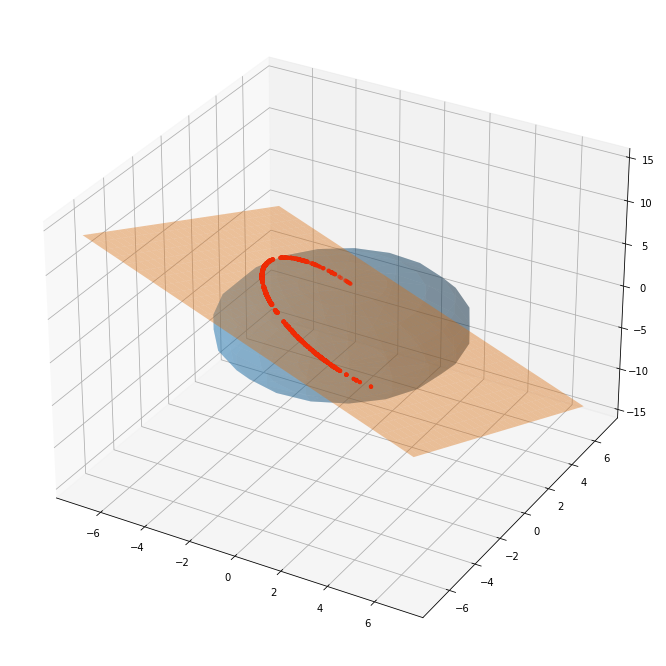

In [6]:
fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')


plot_surface(axis, sphere_mesh, alpha=0.3)
plot_surface(axis, plain_mesh, alpha=0.4)
# plot_mpoints(axis, sphere_manifold_generator(0, 0, 3), c='r', s=10)
# plot_mpoints(axis, plain_manifold_generator(0, 0, 10), c='g', s=10)

plain = plain_manifold_generator(0, 0, 10)
sphere = sphere_manifold_generator(0, 0, 3)

rcubes, rpoints, _ = pyi.optimize3d(plain, sphere, 0.1,
    plain_manifold_generator, sphere_manifold_generator, max_iter=10)

plot_rpoints(axis, rpoints, c='r', s=10)

# 2. Build approximate intersection curve

## 2.1 Clustering intersections points

In [37]:
from sklearn.cluster import k_means
from scipy.spatial.distance import cdist
from scipy.interpolate import splprep, splev
from scipy.optimize import brent

In [43]:
def build_path(D, start):
    """
    Build path trough all nodes using minimum distance stepping
    :param D: distance matrix
    :param start: index of starting node
    :return: path
    """
    visited = [start]
    dist = [0]
    n = D.shape[0]
    while len(visited) < n:
        current = visited[-1]
        next = np.argmin(D[current])
        while next in visited:
            D[current, next] = np.inf
            D[next, current] = np.inf
            next = np.argmin(D[current])
        dist.append(D[current, next])
        D[current, next] = np.inf
        D[next, current] = np.inf
        visited.append(next)
    return np.array(visited), np.array(dist)

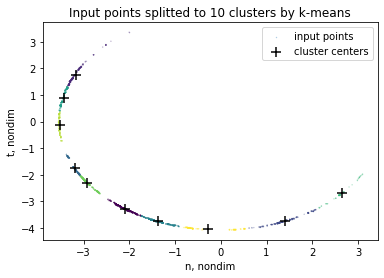

In [69]:
# rpoint is [cid, m, n, t, x, y, z]
points = np.array([*filter(lambda x: x[1] == 0, rpoints)])[:, 2:4]
nclusters = 10
nt_centers, labels, _ = k_means(points, nclusters)

plt.title(f'Input points splitted to {nclusters} clusters by k-means')
plt.scatter(*points.T, c=labels, s=0.1, alpha=0.5, label='input points')
plt.scatter(*nt_centers.T, marker='+', c='k', s=100, label='cluster centers')
plt.xlabel('n, nondim')
plt.ylabel('t, nondim')
plt.legend()
plt.show()

## 2.2 Build distance matrix

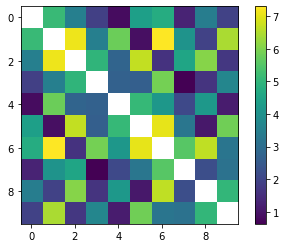

In [70]:
D = cdist(nt_centers, nt_centers)  # distances between cluster centers
start = np.unravel_index(np.argmax(D), D.shape)  # index of starting cluster center
np.fill_diagonal(D, np.inf)

plt.imshow(D)
plt.colorbar()
plt.show()

## 2.3 Building path through cluster centers

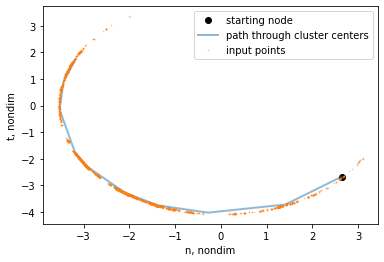

In [71]:
start_node = start[1] # starting node choice need to be done clever
path, dist = build_path(D.copy(), start_node)

if dist.max() > 2 * dist.mean():
    start_node = path[np.argmax(dist)]
    path, dist = build_path(D.copy(), start_node)

plt.plot(nt_centers[start_node, 0], nt_centers[start_node, 1], 'ok', label='starting node')
plt.plot(nt_centers[path, 0], nt_centers[path, 1], alpha=0.5, lw=2, label='path through cluster centers')
plt.plot(*points.T, '.', label='input points', ms=1, alpha=0.5)
plt.xlabel('n, nondim')
plt.ylabel('t, nondim')
plt.legend()
plt.show()

## 2.4 Interpolation using cluster centers

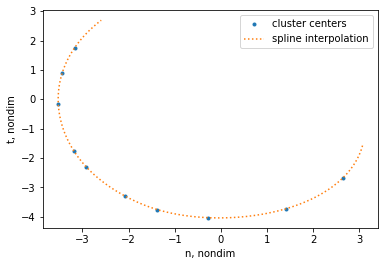

In [72]:
rough_tck, rough_u = splprep(nt_centers[path].T, s=0, k=3)
add_pts = splev(np.linspace(-0.1, 1.1, 200), rough_tck)

plt.plot(*nt_centers[path].T, '.', label='cluster centers')
plt.plot(*add_pts, ':', label='spline interpolation')

plt.xlabel('n, nondim')
plt.ylabel('t, nondim')
plt.legend()
plt.show()

## 2.5 Project input points onto cluster centers spline

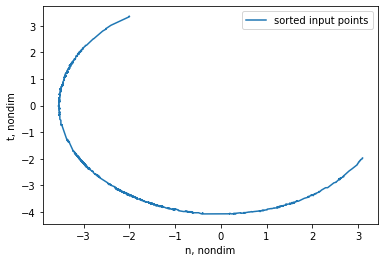

In [73]:
vals = np.empty(points.shape[0])
for i in range(points.shape[0]):
    p = points[i]
    cidx = np.where(path == labels[i])[0][0]
    v0 = rough_u[cidx]
    v = brent(lambda l: np.sum((splev(l, rough_tck) - p) ** 2),
              brack=(v0 - 0.05, v0 + 0.05),
              tol=1e-5)
    vals[i] = v

idx = np.argsort(vals)
plt.plot(*points[idx].T, label='sorted input points')

plt.xlabel('n, nondim')
plt.ylabel('t, nondim')
plt.legend()
plt.show()

## 2.6 Create smooth spline

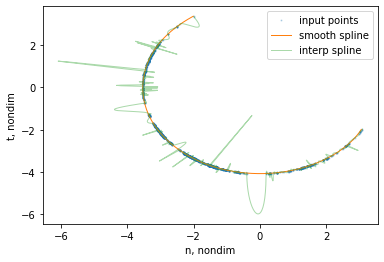

In [74]:
u = vals[idx]
interp_tck, _ = splprep(points[idx].T, u=u, k=3, s=0)
smooth_tck, _ = splprep(points[idx].T, u=u, k=3, s=0.3)
uu = np.linspace(u.min(), u.max(), 1000)
smooth_pts = splev(uu, smooth_tck)
interp_pts = splev(uu, interp_tck)

plt.plot(*points[idx].T, '.', alpha=0.25, ms=2, label='input points')
plt.plot(*smooth_pts, '-', lw=1, label='smooth spline')
plt.plot(*interp_pts, '-', lw=1, alpha=0.4, label='interp spline')
plt.xlabel('n, nondim')
plt.ylabel('t, nondim')
plt.legend()
plt.show()

# 3. Plot intersection using approximate functions

## 3.1 Plot intersection using sphere-manifold n(t) approximate function

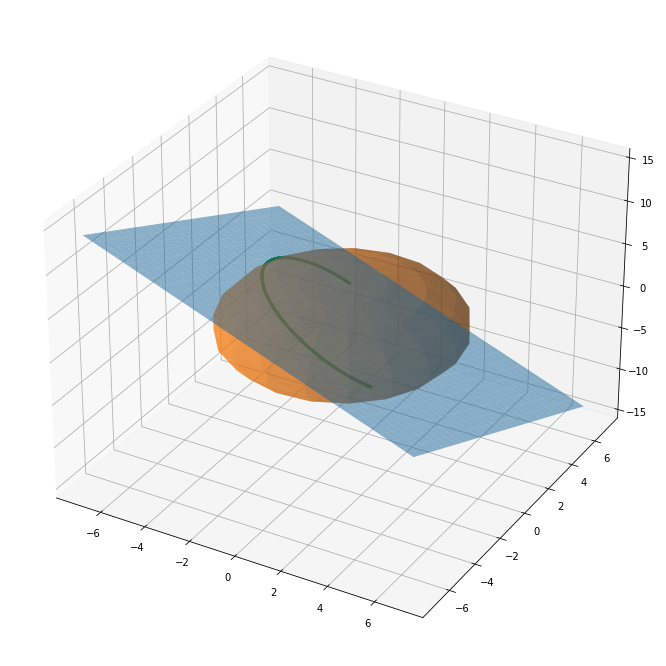

In [78]:
points = []
for i in range(len(smooth_pts[0])):
    points.append(plain_point_generator(smooth_pts[0][i], smooth_pts[1][i]))
points = np.array(points)

# Plot results
fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')
plot_surface(axis, plain_mesh, alpha=0.5)
plot_surface(axis, sphere_mesh, alpha=0.5)
plot_rawpoints(axis, points, c='g', s=4)